# Matrix Factorization Neural Network

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn, optim

# Load dataset
df = pd.read_csv('../data/lens_tmdb/ratings_small.csv')

In [9]:
# Use the LabelEncoder from sklearn to encode the movie and user IDs
user_enc = LabelEncoder()
df['userId'] = user_enc.fit_transform(df['userId'].values)
n_users = df['userId'].nunique()

item_enc = LabelEncoder()
df['movieId'] = item_enc.fit_transform(df['movieId'].values)
n_movies = df['movieId'].nunique()


In [10]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_df = torch.tensor(train_df.values, dtype=torch.float32)
val_df = torch.tensor(val_df.values, dtype=torch.float32)


# Create PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader, TensorDataset

# Convert the tensors into datasets
train_dataset = TensorDataset(train_df[:, 0].long(), train_df[:, 1].long(), train_df[:, 2])
val_dataset = TensorDataset(val_df[:, 0].long(), val_df[:, 1].long(), val_df[:, 2])

# Use DataLoader to iterate over these datasets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)


# Matrix Factorization Model Architecture

In [12]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=20):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.movie_factors = nn.Embedding(n_movies, n_factors)

    def forward(self, user, movie):
        return (self.user_factors(user) * self.movie_factors(movie)).sum(1)


In [13]:
def rmse(predictions, targets):
    return torch.sqrt(((predictions - targets) ** 2).mean())

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and test the model

In [17]:
# Model, Criterion, and Optimizer setup
model_mf = MatrixFactorization(n_users, n_movies, n_factors=50).to(device)
criterion_mf = nn.MSELoss()
optimizer_mf = optim.Adam(model_mf.parameters(), lr=0.001)

# Lists to store metrics
train_losses_mf = []
test_losses_mf = []
rmses_mf = []

num_epochs_mf = 10
for epoch in range(num_epochs_mf):
    model_mf.train()
    train_loss_mf = 0
    for users, movies, ratings in train_loader:
        users, movies, ratings = users.to(device), movies.to(device), ratings.float().to(device)

        optimizer_mf.zero_grad()
        outputs_mf = model_mf(users, movies).squeeze()
        loss_mf = criterion_mf(outputs_mf, ratings)
        loss_mf.backward()
        optimizer_mf.step()

        train_loss_mf += loss_mf.item()

    train_loss_mf /= len(train_loader)
    train_losses_mf.append(train_loss_mf)

    model_mf.eval()
    test_loss_mf = 0
    test_rmse_mf = 0
    with torch.no_grad():
        for users, movies, ratings in val_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.float().to(device)

            outputs_mf = model_mf(users, movies).squeeze()
            loss_mf = criterion_mf(outputs_mf, ratings)

            test_loss_mf += loss_mf.item()
            test_rmse_mf += rmse(outputs_mf, ratings).item()

    test_loss_mf /= len(val_loader)
    test_losses_mf.append(test_loss_mf)

    test_rmse_mf /= len(val_loader)
    rmses_mf.append(test_rmse_mf)

    print(f'Epoch {epoch+1}/{num_epochs_mf}, Train Loss for MF: {train_loss_mf}')
    print(f'Epoch {epoch+1}/{num_epochs_mf}, Test Loss for MF: {test_loss_mf}')
    print(f'Epoch {epoch+1}/{num_epochs_mf}, Test RMSE for MF: {test_rmse_mf}')

Epoch 1/10, Train Loss for MF: 60.932396081308966
Epoch 1/10, Test Loss for MF: 58.21533029290694
Epoch 1/10, Test RMSE for MF: 7.620467192010034
Epoch 2/10, Train Loss for MF: 53.728436661985356
Epoch 2/10, Test Loss for MF: 54.418906296355814
Epoch 2/10, Test RMSE for MF: 7.367816617217245
Epoch 3/10, Train Loss for MF: 47.54705370576999
Epoch 3/10, Test Loss for MF: 51.13960439947587
Epoch 3/10, Test RMSE for MF: 7.142420394511163
Epoch 4/10, Train Loss for MF: 42.28747887047716
Epoch 4/10, Test Loss for MF: 48.27754061735129
Epoch 4/10, Test RMSE for MF: 6.939725199832192
Epoch 5/10, Train Loss for MF: 37.78349585121813
Epoch 5/10, Test Loss for MF: 45.774145005624504
Epoch 5/10, Test RMSE for MF: 6.757465441015702
Epoch 6/10, Train Loss for MF: 33.935664283581815
Epoch 6/10, Test Loss for MF: 43.5631744288191
Epoch 6/10, Test RMSE for MF: 6.59229370913928
Epoch 7/10, Train Loss for MF: 30.6124711143323
Epoch 7/10, Test Loss for MF: 41.60679640951036
Epoch 7/10, Test RMSE for MF: 6

# Plot the training and test losses

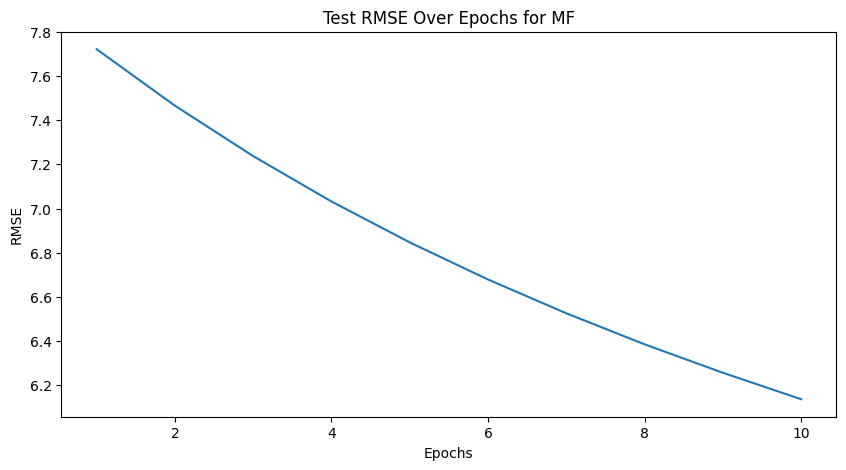

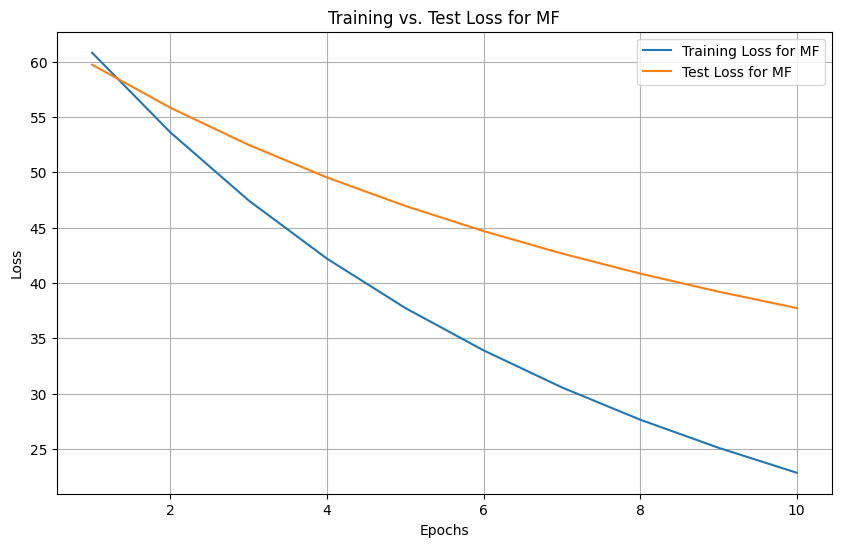

In [16]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs_mf + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs, rmses_mf)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Test RMSE Over Epochs for MF')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses_mf, label="Training Loss for MF")
plt.plot(epochs, test_losses_mf, label="Test Loss for MF")
plt.title("Training vs. Test Loss for MF")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()